# U-Net for Full Body Segmentation (MADS Dataset)

This notebook implements a U-Net model for semantic segmentation using the [Segmentation Full Body MADS Dataset](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset). The goal is to identify the pixels belonging to a person in an image.

We will follow these steps:
1.  **Setup:** Import libraries and define constants.
2.  **File Discovery:** Locate the image and mask files in the dataset directory.
3.  **Data Loading & Preprocessing:** Load images and masks, resize them, and normalize pixel values.
4.  **Data Splitting:** Divide the data into training and testing sets.
5.  **Exploratory Data Analysis (EDA):** Visualize some sample images and their corresponding masks.
6.  **Model Definition:** Build the U-Net architecture using Keras functional API.
7.  **Metrics & Loss:** Define the Jaccard coefficient (IoU) metric and Jaccard loss function.
8.  **Model Compilation & Training:** Compile the U-Net model with the specified optimizer, loss, and metrics, then train it on the prepared data using the selected hyperparameters.
9.  **Training History:** Plot the training and validation loss and IoU over epochs.
10. **Evaluation:** Evaluate the trained model on the held-out test set.
11. **Prediction & Visualization:** Generate predictions on the test set and visualize the input image, true mask, and predicted mask for a sample.

---

## 1. Setup: Imports and Configuration

Import necessary libraries (TensorFlow/Keras, NumPy, Matplotlib, OS) and define key constants like image dimensions and dataset paths.


In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate

# --- Configuration & Setup ---
# Define constants for image dimensions and dataset paths
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
MASK_CHANNELS = 1 # Binary segmentation (foreground/background)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Adjust KAGGLE_INPUT_DIR if running locally
KAGGLE_INPUT_DIR = '/kaggle/input'
# Assuming the dataset is directly under this input directory structure
DATASET_BASE_DIR = os.path.join(KAGGLE_INPUT_DIR, 'segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img')

# Define specific directories for images and masks
IMAGE_DIR = os.path.join(DATASET_BASE_DIR, 'images')
MASK_DIR = os.path.join(DATASET_BASE_DIR, 'masks')

# Set a random seed for reproducibility if needed (optional)
# SEED = 42
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

print("Libraries imported and configuration set.")
print(f"Image directory: {IMAGE_DIR}")
print(f"Mask directory: {MASK_DIR}")

Libraries imported and configuration set.
Image directory: /kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images
Mask directory: /kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks


---

## 2. File Discovery

Locate and list the image and mask files within their respective directories. We sort the filenames to ensure consistent pairing and perform basic checks.


In [19]:
# --- File Discovery ---
print("--- Locating Input Files ---")
# Use sorted for consistent ordering between images and masks
try:
    image_filenames = sorted(os.listdir(IMAGE_DIR))
    mask_filenames = sorted(os.listdir(MASK_DIR))
except FileNotFoundError:
    print(f"Error: Could not find directories {IMAGE_DIR} or {MASK_DIR}.")
    print("Please ensure the KAGGLE_INPUT_DIR and DATASET_BASE_DIR are correct.")
    # Stop execution if directories aren't found
    raise

num_images = len(image_filenames)
num_masks = len(mask_filenames)

print(f"Found {num_images} images in {IMAGE_DIR}")
print(f"Found {num_masks} masks in {MASK_DIR}")

# Basic validation checks
if num_images != num_masks:
    raise ValueError("Mismatch between the number of images and masks found!")
if num_images == 0:
    raise ValueError("No images/masks found. Check the directory paths and dataset structure.")

print("File discovery complete.")
print("-" * 30)

--- Locating Input Files ---
Found 1192 images in /kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images
Found 1192 masks in /kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks
File discovery complete.
------------------------------


---

## 3. Data Loading and Preprocessing

Load the images and masks from the discovered files. Resize them to the target dimensions (`IMG_WIDTH`, `IMG_HEIGHT`). Normalize the pixel values to the range [0, 1] by dividing by 255. Masks are loaded in grayscale.

In [20]:
# --- Data Loading and Preprocessing ---
print("--- Loading and Preprocessing Data ---")

# Pre-allocate NumPy arrays for efficiency
image_data = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
mask_data = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH, MASK_CHANNELS), dtype=np.float32) # Expecting (H, W, 1)

# Load images
print("Loading images...")
for i, filename in enumerate(image_filenames):
    img_path = os.path.join(IMAGE_DIR, filename)
    # Load image in color (RGB) and resize
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="rgb")
    image_data[i] = img_to_array(img)

# Load masks
print("Loading masks...")
for i, filename in enumerate(mask_filenames):
    mask_path = os.path.join(MASK_DIR, filename)
    # Load mask in grayscale and resize
    mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    mask_data[i] = img_to_array(mask) # Resulting shape is (H, W, 1)

# Normalize pixel values to [0, 1]
print("Normalizing data (dividing by 255)...")
image_data /= 255.0
mask_data /= 255.0
# Note: Masks are normalized. The sigmoid output layer and loss function will handle the segmentation task.
# Loaded masks might not be strictly binary {0, 1} after resizing and normalization.

print("Data loading and preprocessing complete.")
print(f"Image data shape: {image_data.shape}")
print(f"Mask data shape: {mask_data.shape}")
print(f"Image data type: {image_data.dtype}")
print(f"Mask data type: {mask_data.dtype}")
print(f"Min/Max image values: {np.min(image_data):.2f}/{np.max(image_data):.2f}")
print(f"Min/Max mask values: {np.min(mask_data):.2f}/{np.max(mask_data):.2f} (Unique values: {np.unique(mask_data)})")
print("-" * 30)

--- Loading and Preprocessing Data ---
Loading images...
Loading masks...
Normalizing data (dividing by 255)...
Data loading and preprocessing complete.
Image data shape: (1192, 256, 256, 3)
Mask data shape: (1192, 256, 256, 1)
Image data type: float32
Mask data type: float32
Min/Max image values: 0.00/1.00
Min/Max mask values: 0.00/1.00 (Unique values: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352

---

## 4. Data Splitting

Split the loaded data into training and testing sets. The first 10 samples are used for testing, and the remaining samples are used for training. The training data will be further split into training and validation sets during the `model.fit` call.

In [21]:
# --- Data Splitting ---
print("--- Splitting Data ---")
# Use simple slicing: first 10 for testing, rest for training.
if num_images <= 10:
    raise ValueError("Not enough images for the chosen train/test split (need more than 10).")

# Test set: First 10 samples
test_images = image_data[0:10]
test_masks = mask_data[0:10]

# Training set: All samples *after* the first 10
train_images = image_data[10:]
train_masks = mask_data[10:]

# Note: A separate validation set is NOT created here.
# Validation will happen using the `validation_split` argument in `model.fit`,
# which will take a portion of the `train_images` and `train_masks`.

print(f"Total samples: {num_images}")
print(f"Training samples (input to model.fit): {len(train_images)}")
print(f"Test samples: {len(test_images)}")
print(f"Shape of train_images: {train_images.shape}")
print(f"Shape of train_masks: {train_masks.shape}")
print(f"Shape of test_images: {test_images.shape}")
print(f"Shape of test_masks: {test_masks.shape}")
print("-" * 30)

--- Splitting Data ---
Total samples: 1192
Training samples (input to model.fit): 1182
Test samples: 10
Shape of train_images: (1182, 256, 256, 3)
Shape of train_masks: (1182, 256, 256, 1)
Shape of test_images: (10, 256, 256, 3)
Shape of test_masks: (10, 256, 256, 1)
------------------------------


---

## 5. Exploratory Data Analysis (EDA)

Visualize a few examples from the dataset to understand the input images and their corresponding ground truth segmentation masks. We define a helper function to plot image-mask pairs.

--- Exploratory Data Analysis ---
Plotting the first sample (Index 0) from the overall dataset (used in the test set):


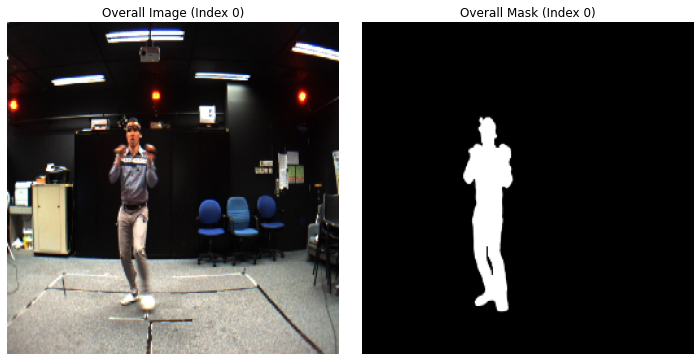


Plotting the first sample available in the training set:


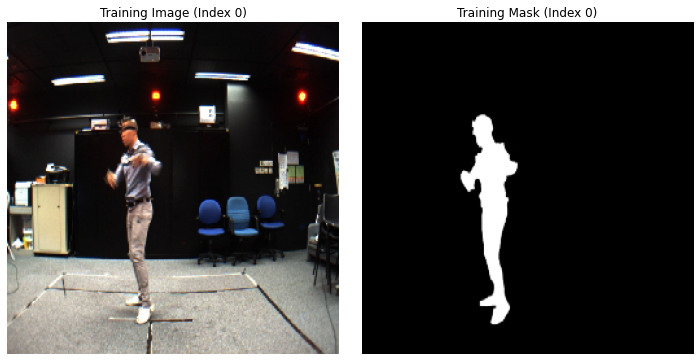

------------------------------


In [22]:
# --- Exploratory Data Analysis (EDA) ---
print("--- Exploratory Data Analysis ---")

def plot_sample_images_masks(images, masks, sample_indices, dataset_label="Dataset"):
    """Plots specific image-mask pairs based on indices."""
    num_samples = len(sample_indices)
    if num_samples == 0:
        print("No indices provided for plotting.")
        return

    plt.figure(figsize=(10, 5 * num_samples)) # Adjust figure size based on number of samples

    for i, idx in enumerate(sample_indices):
        if idx >= len(images):
            print(f"Warning: Index {idx} is out of bounds for the '{dataset_label}' set (size {len(images)}).")
            continue

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[idx])
        plt.title(f"{dataset_label} Image (Index {idx})")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        # Use cmap='gray' and squeeze() for single-channel masks
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.title(f"{dataset_label} Mask (Index {idx})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the first sample (index 0 from the full dataset, which is in the test set)
print("Plotting the first sample (Index 0) from the overall dataset (used in the test set):")
plot_sample_images_masks(image_data, mask_data, [0], dataset_label="Overall")

# Plot the first sample from the training set (corresponding to index 10 of the full dataset)
print("\nPlotting the first sample available in the training set:")
# We use train_images[0] which corresponds to image_data[10]
plot_sample_images_masks(train_images, train_masks, [0], dataset_label="Training")

# Optional: Plot a sample from the test set explicitly
# print("\nPlotting the second sample (Index 1) from the test set:")
# plot_sample_images_masks(test_images, test_masks, [1], dataset_label="Test")

print("-" * 30)

---

## 6. Model Definition (U-Net)

Define the U-Net model architecture. This involves creating helper functions for the standard blocks of the U-Net:
* `double_conv_block`: Two consecutive convolution layers with Batch Normalization and LeakyReLU activation.
* `encoder_block`: A `double_conv_block` followed by MaxPooling (for downsampling). It returns both the pooled output and the pre-pool output (skip connection).
* `decoder_block`: Transposed convolution (for upsampling), concatenation with the corresponding skip connection from the encoder path, followed by a `double_conv_block`.

The `build_unet` function puts these blocks together to form the complete U-Net.

In [ ]:
# --- Model Definition (U-Net) ---
print("--- Defining U-Net Model Architecture ---")

def double_conv_block(input_tensor, n_filters, kernel_size=3, batch_norm=True):
    """Creates a block of two convolutional layers with Batch Normalization and LeakyReLU activation."""
    # First Conv Layer
    x = Conv2D(n_filters, kernel_size, padding='same', kernel_initializer='he_normal', use_bias=not batch_norm)(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    # Second Conv Layer
    x = Conv2D(n_filters, kernel_size, padding='same', kernel_initializer='he_normal', use_bias=not batch_norm)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def encoder_block(input_tensor, n_filters, pool_size=(2, 2), max_pool=True):
    """Encoder block: Double convolution followed by Optional Max Pooling."""
    # Get the output of the double conv block to use as skip connection
    skip_connection = double_conv_block(input_tensor, n_filters)
    # Apply max pooling if required
    if max_pool:
        next_layer = MaxPool2D(pool_size=pool_size)(skip_connection)
    else:
        # If no max pooling, the 'next_layer' is just the output of the conv block
        next_layer = skip_connection
    return next_layer, skip_connection # Return pooled/non-pooled layer and the skip connection output

def decoder_block(input_tensor, skip_connection_tensor, n_filters, kernel_size=3, strides=2, batch_norm=True):
    """Decoder block: Upsampling (Conv2DTranspose), concatenation with skip connection, and double convolution."""
    # Upsample using Conv2DTranspose
    upsample = Conv2DTranspose(n_filters, kernel_size, strides=strides, padding='same')(input_tensor)
    # Concatenate the upsampled feature map with the corresponding skip connection
    merged = concatenate([upsample, skip_connection_tensor], axis=3)
    # Pass the merged tensor through a double convolution block
    conv_output = double_conv_block(merged, n_filters, batch_norm=batch_norm)
    return conv_output

def build_unet(input_shape=INPUT_SHAPE, num_classes=1, base_filters=32):
    """Builds the U-Net model."""
    inputs = Input(shape=input_shape)

    # Encoder Path (Contracting Path)
    enc1_next, enc1_skip = encoder_block(inputs, base_filters)         # Filters: 32
    enc2_next, enc2_skip = encoder_block(enc1_next, base_filters*2)     # Filters: 64
    enc3_next, enc3_skip = encoder_block(enc2_next, base_filters*4)     # Filters: 128
    enc4_next, enc4_skip = encoder_block(enc3_next, base_filters*8)     # Filters: 256

    # Bottleneck (No pooling here, only convolution) 
    bottleneck_next, bottleneck_skip = encoder_block(enc4_next, base_filters*16, max_pool=False) # Filters: 512

    # Decoder Path (Expansive Path)
    # Note: The input to decoder block is the output from the *previous* block's pooling/conv layer.
    #       The skip connection comes from the *same* level in the encoder.
    dec1 = decoder_block(bottleneck_skip, enc4_skip, base_filters*8)  # Input from bottleneck, skip from enc4. Filters: 256
    dec2 = decoder_block(dec1, enc3_skip, base_filters*4)             # Input from dec1, skip from enc3. Filters: 128
    dec3 = decoder_block(dec2, enc2_skip, base_filters*2)             # Input from dec2, skip from enc2. Filters: 64
    dec4 = decoder_block(dec3, enc1_skip, base_filters)               # Input from dec3, skip from enc1. Filters: 32

    # Final Convolutional Layers before output
    # Apply one more set: Conv2D(32) -> BN -> LeakyReLU
    final_conv = Conv2D(base_filters, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(dec4)
    final_bn = BatchNormalization()(final_conv)
    final_lrl = LeakyReLU(alpha=0.2)(final_bn)

    # Output Layer
    if num_classes == 1:
      activation = 'sigmoid' # For binary segmentation
    else:
      activation = 'softmax' # For multi-class segmentation

    # Final 1x1 Convolution to get the desired number of output channels (masks)
    segmentation_output = Conv2D(num_classes, (1, 1), padding='same', activation=activation)(final_lrl)

    unet_model = Model(inputs=inputs, outputs=segmentation_output, name="UNet_Model")
    return unet_model

print("U-Net definition functions complete.")
print("-" * 30)

--- Defining U-Net Model Architecture ---
U-Net definition functions complete.
------------------------------


---

## 7. Metrics and Loss Functions

Define the metrics and loss function used for training and evaluation. We will use the Jaccard Coefficient (Intersection over Union - IoU) as the evaluation metric and the negative Jaccard Coefficient (Jaccard Loss) as the loss function. `SMOOTH` is added to prevent division by zero.



In [24]:
# --- Metrics and Loss Functions ---
print("--- Defining Metrics and Loss Functions ---")

SMOOTH = 1.0 # Use float for consistency

# Jaccard Coefficient (Intersection over Union - IoU)
# Computes the mean IoU over the batch
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    # Add smoothing factor
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    return iou

# Jaccard Loss (-IoU because optimization aims to minimize loss)
def jaccard_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

print(f"Metric: Jaccard Coefficient (IoU) using SMOOTH={SMOOTH}")
print(f"Loss: Jaccard Loss (-IoU) using SMOOTH={SMOOTH}")
print("-" * 30)

--- Defining Metrics and Loss Functions ---
Metric: Jaccard Coefficient (IoU) using SMOOTH=1.0
Loss: Jaccard Loss (-IoU) using SMOOTH=1.0
------------------------------


---

## 8. Model Compilation and Training

Instantiate the U-Net model, compile it using the Adam optimizer, the defined Jaccard loss, and the Jaccard coefficient metric. Then, train the model using the training data. We set the hyperparameters: learning rate, batch size, epochs, and validation split percentage.


In [25]:
# --- Model Compilation and Training ---
print("--- Compiling and Training the Model ---")

# Instantiate the model
unet_model = build_unet(input_shape=INPUT_SHAPE, num_classes=MASK_CHANNELS, base_filters=32)

# Display model summary (Optional but highly recommended)
unet_model.summary()

# Optional: Plot model architecture to a file (requires pydot and graphviz)
try:
    MODEL_PLOT_FILE = "unet_model_architecture.png"
    keras.utils.plot_model(unet_model, to_file=MODEL_PLOT_FILE, show_shapes=True, show_layer_names=True, dpi=96)
    print(f"Model architecture saved to {MODEL_PLOT_FILE}")
except ImportError:
    print("Note: 'pydot' or 'graphviz' not found. Skipping model plot generation.")
    print("Install them ('pip install pydot graphviz') and potentially Graphviz OS binaries if you want the plot.")

# Compile the model
LEARNING_RATE = 1e-3 # Set learning rate (0.001)
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Adam optimizer
LOSS_FUNCTION = jaccard_loss # Jaccard loss
METRICS = [jaccard_coef] # Jaccard coefficient (IoU) metric

unet_model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)
print(f"\nModel compiled with Optimizer: Adam (LR={LEARNING_RATE}), Loss: Jaccard Loss, Metrics: [Jaccard Coef]")

# Training parameters
BATCH_SIZE = 32 # Set batch size
EPOCHS = 20 # Set number of epochs
VALIDATION_SPLIT = 0.2 # Percentage of training data to use for validation

print(f"\nStarting training with:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Validation Split: {VALIDATION_SPLIT*100:.1f}% of training data")

# Train the model
# `validation_split` will automatically take the last 20% of `train_images`/`train_masks` for validation
history = unet_model.fit(
    train_images, train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=1 # Set to 1 for progress bar, 2 for one line per epoch, 0 for silent
)

print("\nTraining finished.")
print("-" * 30)

--- Compiling and Training the Model ---
Model: "UNet_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 256, 256, 32) 128         conv2d_78[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_74 (LeakyReLU)      (None, 256, 256, 32) 0           batch_normalization_74[0][0]     
________________________________________________

---

## 9. Plot Training History

Visualize the training process by plotting the loss (Jaccard Loss) and metric (Jaccard Coefficient/IoU) for both the training and validation sets over the epochs. This helps in understanding model convergence and potential overfitting.


--- Plotting Training History ---


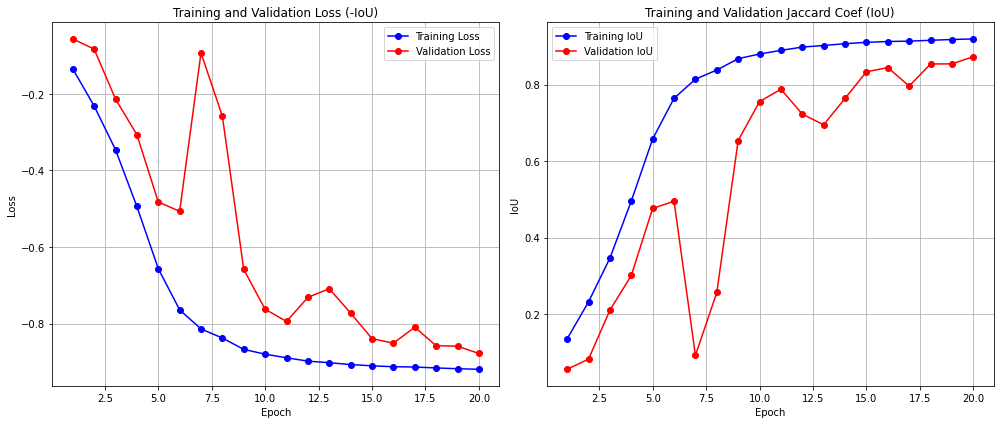

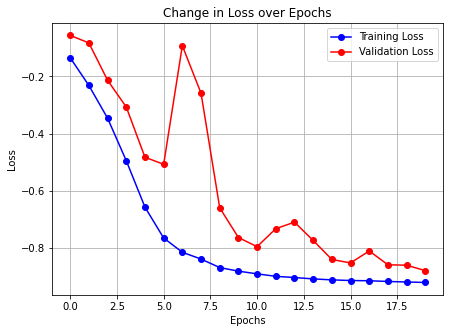

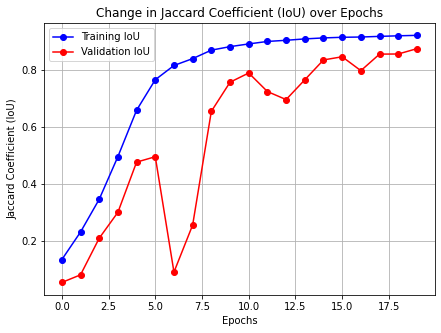

------------------------------


In [26]:
# --- Plot Training History ---
print("--- Plotting Training History ---")

def plot_training_history(history):
    """Plots loss and metrics curves for training and validation sets."""
    history_dict = history.history
    epochs_range = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Loss (Jaccard Loss = -IoU)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_dict['loss'], 'bo-', label='Training Loss')
    if 'val_loss' in history_dict:
        plt.plot(epochs_range, history_dict['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss (-IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Metric (Jaccard Coef = IoU)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_dict['jaccard_coef'], 'bo-', label='Training IoU')
    if 'val_jaccard_coef' in history_dict:
        plt.plot(epochs_range, history_dict['val_jaccard_coef'], 'ro-', label='Validation IoU')
    plt.title('Training and Validation Jaccard Coef (IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.ylim(bottom=max(0, plt.ylim()[0]), top=min(1, plt.ylim()[1])) # Set IoU y-axis limits [0, 1] if possible
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot combined history using the function
plot_training_history(history)

# Plot Loss Change Separately
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], 'bo-')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], 'ro-')
    plt.legend(['Training Loss', 'Validation Loss'])
else:
     plt.legend(['Training Loss'])
plt.title('Change in Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot IoU Change Separately
plt.figure(figsize=(7, 5))
plt.plot(history.history['jaccard_coef'], 'bo-')
if 'val_jaccard_coef' in history.history:
     plt.plot(history.history['val_jaccard_coef'], 'ro-')
     plt.legend(['Training IoU', 'Validation IoU'])
else:
    plt.legend(['Training IoU'])
plt.title('Change in Jaccard Coefficient (IoU) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Jaccard Coefficient (IoU)')
plt.ylim(bottom=max(0, plt.ylim()[0]), top=min(1, plt.ylim()[1])) # Set IoU y-axis limits [0, 1] if possible
plt.grid(True)
plt.show()

print("-" * 30)

---

## 10. Model Evaluation on Test Set

Evaluate the performance of the trained model on the held-out test set (the first 10 samples). This provides an estimate of the model's generalization ability on unseen data. We report the final test loss and test IoU.


In [27]:
# --- Model Evaluation on Test Set ---
print("--- Evaluating Model Performance on Test Set ---")
# Evaluate performance on the held-out test data.
evaluation_results = unet_model.evaluate(test_images, test_masks, batch_size=BATCH_SIZE, verbose=0) # verbose=0 for less output

print("Test Set Evaluation Results:")
# evaluation_results[0] is the loss (jaccard_loss), evaluation_results[1] is the metric (jaccard_coef)
print(f"  Test Loss (-IoU): {evaluation_results[0]:.4f}")
print(f"  Test Jaccard Coef (IoU): {evaluation_results[1]:.4f}")
print("-" * 30)

--- Evaluating Model Performance on Test Set ---
Test Set Evaluation Results:
  Test Loss (-IoU): -0.9022
  Test Jaccard Coef (IoU): 0.9022
------------------------------


---

## 11. Prediction and Visualization

Use the trained model to generate segmentation predictions on the test images. The raw output of the model (sigmoid activation) gives pixel-wise probabilities. We apply a threshold of 0.5 to convert these probabilities into a binary mask. Finally, we visualize the input image, the ground truth mask, and the model's predicted mask for a sample from the test set.


--- Generating Predictions and Visualizing Results ---
Generating predictions for 10 test images...
Predictions generated with shape: (10, 256, 256, 1)
Applying threshold (0.5) to convert predictions to binary masks...
Binary predicted masks created with shape: (10, 256, 256, 1)
Unique values in predicted mask sample 0: [0. 1.]

Plotting prediction result for the first test sample (Index 0):


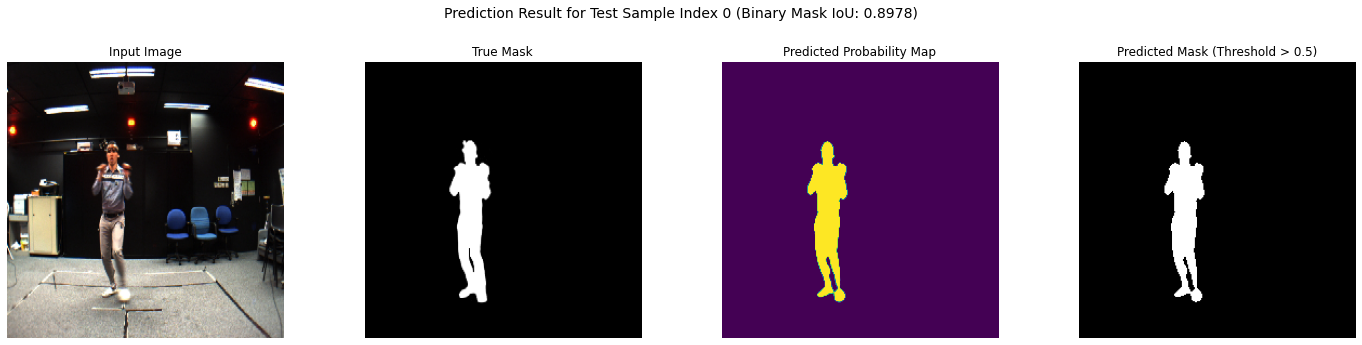

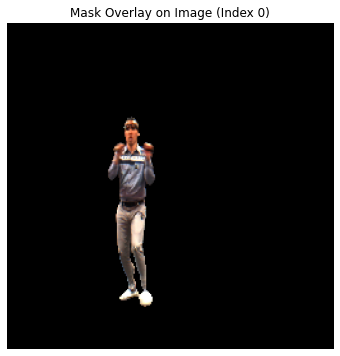

--- Prediction and Visualization Complete ---


In [28]:
# --- Generating Predictions and Visualizing Results ---
print("--- Generating Predictions and Visualizing Results ---")

# Generate predictions on the test set
print(f"Generating predictions for {len(test_images)} test images...")
test_predictions = unet_model.predict(test_images, batch_size=BATCH_SIZE)
print(f"Predictions generated with shape: {test_predictions.shape}") # Should be (10, 256, 256, 1)

# Threshold predictions to create binary masks
def create_binary_mask(predictions, threshold=0.5):
    """Converts probability maps to binary masks based on a threshold."""
    # Create a mask of the same shape and type, initially all zeros
    binary_mask = np.zeros_like(predictions, dtype=np.float32)
    # Where the prediction is greater than the threshold, set the mask value to 1.0
    binary_mask[predictions > threshold] = 1.0
    return binary_mask

print(f"Applying threshold ({0.5}) to convert predictions to binary masks...")
predicted_masks = create_binary_mask(test_predictions, threshold=0.5)
print(f"Binary predicted masks created with shape: {predicted_masks.shape}")
print(f"Unique values in predicted mask sample 0: {np.unique(predicted_masks[0])}")

# Visualize results for one sample
def plot_single_prediction_result(image, true_mask, predicted_prob_map, predicted_binary_mask, sample_index):
    """Plots input, true mask, predicted probability map, and final predicted mask for one sample."""
    f = plt.figure(figsize=(20, 5)) # Adjusted size for better viewing

    # Calculate IoU for this specific sample using the defined function
    # Ensure inputs are tf.Tensors or compatible NumPy arrays with float32 type
    true_mask_tf = tf.constant(true_mask, dtype=tf.float32)
    predicted_binary_mask_tf = tf.constant(predicted_binary_mask, dtype=tf.float32)
    sample_iou = jaccard_coef(true_mask_tf, predicted_binary_mask_tf).numpy()

    plt.suptitle(f"Prediction Result for Test Sample Index {sample_index} (Binary Mask IoU: {sample_iou:.4f})", fontsize=14)

    # Input Image
    f.add_subplot(1, 4, 1)
    plt.title('Input Image')
    plt.imshow(image)
    plt.axis('off')

    # True Mask
    f.add_subplot(1, 4, 2)
    plt.title('True Mask')
    plt.imshow(true_mask.squeeze(), cmap='gray') # squeeze to remove channel dim for grayscale plotting
    plt.axis('off')

    # Predicted Probability Map (Raw Sigmoid Output)
    f.add_subplot(1, 4, 3)
    plt.title('Predicted Probability Map')
    plt.imshow(predicted_prob_map.squeeze(), cmap='viridis') # Use a colormap like viridis for probabilities
    plt.axis('off')

    # Predicted Binary Mask (Thresholded)
    f.add_subplot(1, 4, 4)
    plt.title(f'Predicted Mask (Threshold > 0.5)')
    plt.imshow(predicted_binary_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout to prevent title overlap
    plt.show()

    # Generate the overlay plot separately
    plt.figure(figsize=(6, 6))
    plt.title(f"Mask Overlay on Image (Index {sample_index})")
    # Ensure predicted_mask is broadcastable for multiplication if needed (should be fine here)
    overlay_image = image * predicted_binary_mask # Element-wise multiplication highlights segmented area
    plt.imshow(overlay_image)
    plt.axis('off')
    plt.show()


# Plot results for the first test sample (index 0)
print("\nPlotting prediction result for the first test sample (Index 0):")
plot_single_prediction_result(test_images[0], test_masks[0], test_predictions[0], predicted_masks[0], 0)

# Optional: Plot results for another test sample if desired
# print("\nPlotting prediction result for the second test sample (Index 1):")
# plot_single_prediction_result(test_images[1], test_masks[1], test_predictions[1], predicted_masks[1], 1)

print("--- Prediction and Visualization Complete ---")

---

## 12. Conclusion

This notebook demonstrated the process of training a U-Net model for full-body semantic segmentation using the MADS dataset. The steps included data loading, preprocessing, model definition using the U-Net architecture, selection of Jaccard Loss and IoU metric, and training with specified hyperparameters. The results show the model's ability to learn the segmentation task, visualized through training history plots and prediction examples on the test set.

---